<a href="https://colab.research.google.com/github/rydr0/Sat_Image_Dataset/blob/master/TrainRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports and setup


In [ ]:
!nvidia-smi

Tue Sep  8 03:54:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! git clone https://github.com/rydr0/Sat_Image_Dataset.git

Cloning into 'Sat_Image_Dataset'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 138630 (delta 45), reused 58 (delta 21), pack-reused 138545
Receiving objects: 100% (138630/138630), 1.35 GiB | 20.48 MiB/s, done.
Resolving deltas: 100% (71327/71327), done.
Checking out files: 100% (92905/92905), done.


In [ ]:
!pip install pytorch.ignite
!pip install geopandas
!pip install gdal

     |████████████████████████████████| 174kB 5.7MB/s 
     |████████████████████████████████| 972kB 8.3MB/s 
     |████████████████████████████████| 14.8MB 207kB/s 
     |████████████████████████████████| 10.9MB 55.9MB/s 


In [ ]:
from torchsummary import summary
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sys
import geopandas as gpd
import gdal
import pprint


from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import ModelCheckpoint

%matplotlib inline

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

In [ ]:
# Load functions from Helper Files
sys.path.append('/content/Sat_Image_Dataset')
from DatasetandDataLoader import *
from Helpers import *
from Training_Regression import *
from Visualisation import *
from Neural_Network import *

# Load Datasets

In [ ]:
# Load dataset to be used in training
train_dataset_model, test_dataset, sat_mean, sat_std = load_datasets(flip=False)

Mean for image channels:
tensor([[[[ 481.4347]],

         [[ 661.0318]],

         [[ 633.2782]],

         [[2610.5615]],

         [[1754.3627]],

         [[2808.4644]],

         [[ 987.0544]]]], dtype=torch.float64)
Standard deviation for image channels:
tensor([[[[182.0427]],

         [[221.7736]],

         [[282.7514]],

         [[989.6967]],

         [[604.5539]],

         [[463.1821]],

         [[403.9931]]]], dtype=torch.float64)
NAN pixel values found and replaced:1944166
Percentage of total pixels:0.026403685596329832
Training Set Images: 37994
NAN pixel values found and replaced:442414
Percentage of total pixels:0.025244303949147805
Test Set Images: 8450


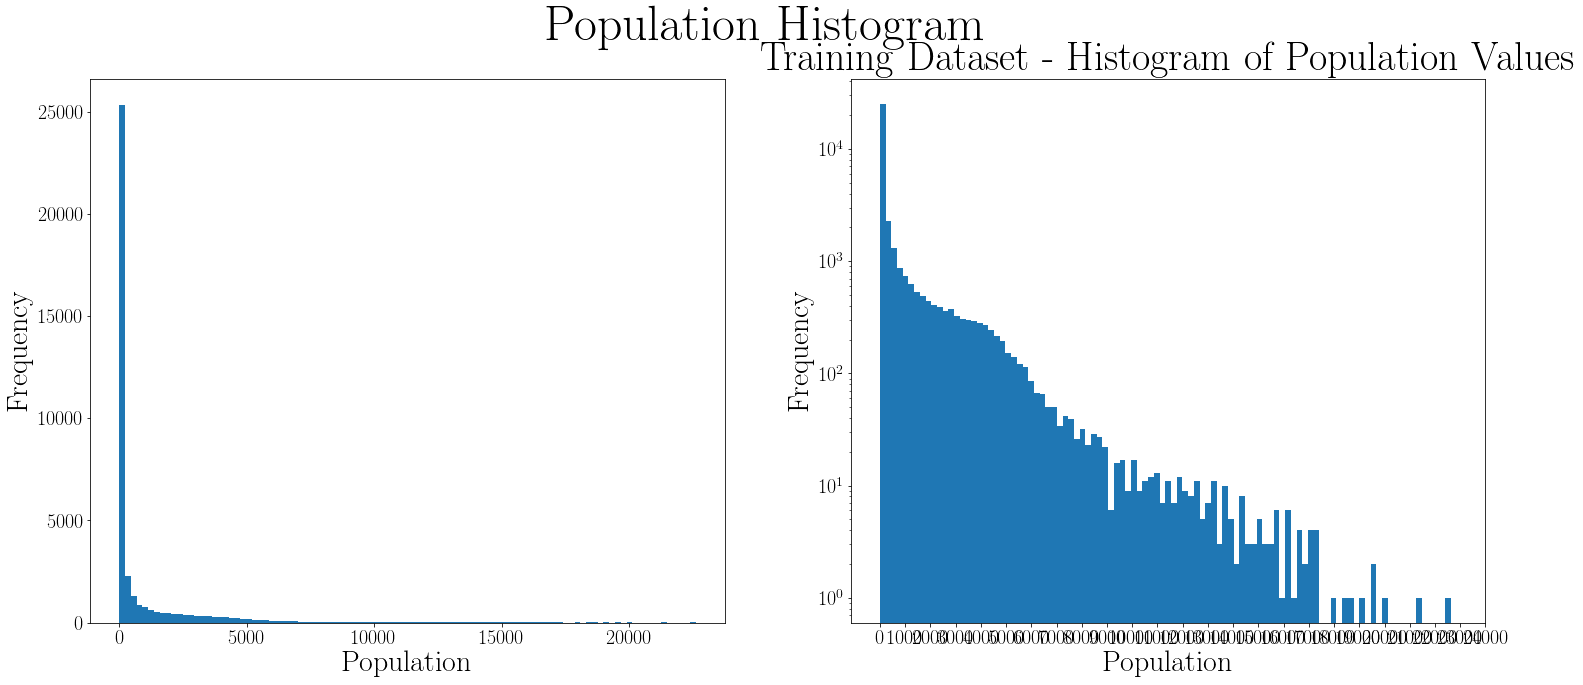

In [ ]:
hist1 = population_hist(train_dataset_model, bins=100)
plt.title("Training Dataset - Histogram of Population Values")
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Population")
plt.xticks(np.arange(0,25)*1000)
plt.show()

# Prepare DataLoader, Batches and Hyperparameters

In [ ]:
num_samples = len(train_dataset_model)
train_samples = int(len(train_dataset_model) * 0.9) # representing 90/10 train/val split
val_samples = num_samples - train_samples
print("""Total Samples: {total}
Training Samples: {train}
Validation Samples: {val}""".format(total=num_samples, train=train_samples, val=val_samples))

Total Samples: 37994
Training Samples: 34194
Validation Samples: 3800


In [ ]:
seed = 121
np.random.seed = seed
torch.manual_seed(seed)
indices = np.arange(num_samples)
np.random.shuffle(indices)

In [ ]:
tr_sampler = torch.utils.data.SubsetRandomSampler(indices[:train_samples])
val_sampler = torch.utils.data.SubsetRandomSampler(indices[train_samples:num_samples])

In [ ]:
tr_batch_size = 512
val_batch_size = val_samples

train_loader = torch.utils.data.DataLoader(train_dataset_model,
                                           batch_size=tr_batch_size,
                                           shuffle=False,
                                           sampler=tr_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset_model,
                                         batch_size=val_batch_size,
                                         shuffle=False,
                                         sampler=val_sampler)

In [ ]:
print("""Number of Training Batches: {tr_batch}
Number of Validation Batches: {val_batch}""".format(tr_batch=len(train_loader), val_batch=len(val_loader)))

Number of Training Batches: 67
Number of Validation Batches: 1


# Testing Different Loss Functions

## Mean Squared Error

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_mse = Neural_Network(config='16', batch_norm=True, mode='reg')
model_mse = model_mse.float()
model_mse.to(device)

print("Model Loaded")

Model Loaded


In [ ]:
model_mse_result = run_training(model_mse,
                                dataset=train_dataset_model,
                                t_loader=train_loader,
                                v_loader=val_loader,
                                criterion=torch.nn.MSELoss(),
                                max_epochs=50,
                                flip=True,
                                flip_prob=0.25,
                                initial_lr=0.001,
                                pbar=False,
                                checkpoint=False,
                                save_as="regmse",
                                weight_decay=1e-5)

Epoch: 1
Training -- Avg loss: 460006.6916, RMSE: 678.2379
Validation -- Avg loss: 452093.9062, RMSE: 672.3793
Epoch: 2
Training -- Avg loss: 740744.7856, RMSE: 860.6653
Validation -- Avg loss: 699311.9375, RMSE: 836.2487
Epoch: 3
Training -- Avg loss: 367016.2619, RMSE: 605.8187
Validation -- Avg loss: 368612.0625, RMSE: 607.1343
Epoch: 4
Training -- Avg loss: 277668.4093, RMSE: 526.9425
Validation -- Avg loss: 283057.1562, RMSE: 532.0312
Epoch: 5
Training -- Avg loss: 1142436.7980, RMSE: 1068.8484
Validation -- Avg loss: 1153016.1250, RMSE: 1073.7859
Epoch: 6
Training -- Avg loss: 360846.7380, RMSE: 600.7052
Validation -- Avg loss: 372923.8438, RMSE: 610.6749
Epoch: 7
Training -- Avg loss: 246637.8850, RMSE: 496.6265
Validation -- Avg loss: 271747.2188, RMSE: 521.2938
Epoch: 8
Training -- Avg loss: 294144.7063, RMSE: 542.3511
Validation -- Avg loss: 319859.4062, RMSE: 565.5612
Epoch: 9
Training -- Avg loss: 282787.8106, RMSE: 531.7780
Validation -- Avg loss: 292008.9688, RMSE: 540.37

In [ ]:
parameters = torch.load('/content/drive/My Drive/Dissertation Files/Models/regmse_LowestLossEpoch42')
model_mse.load_state_dict(parameters['model'])

<All keys matched successfully>

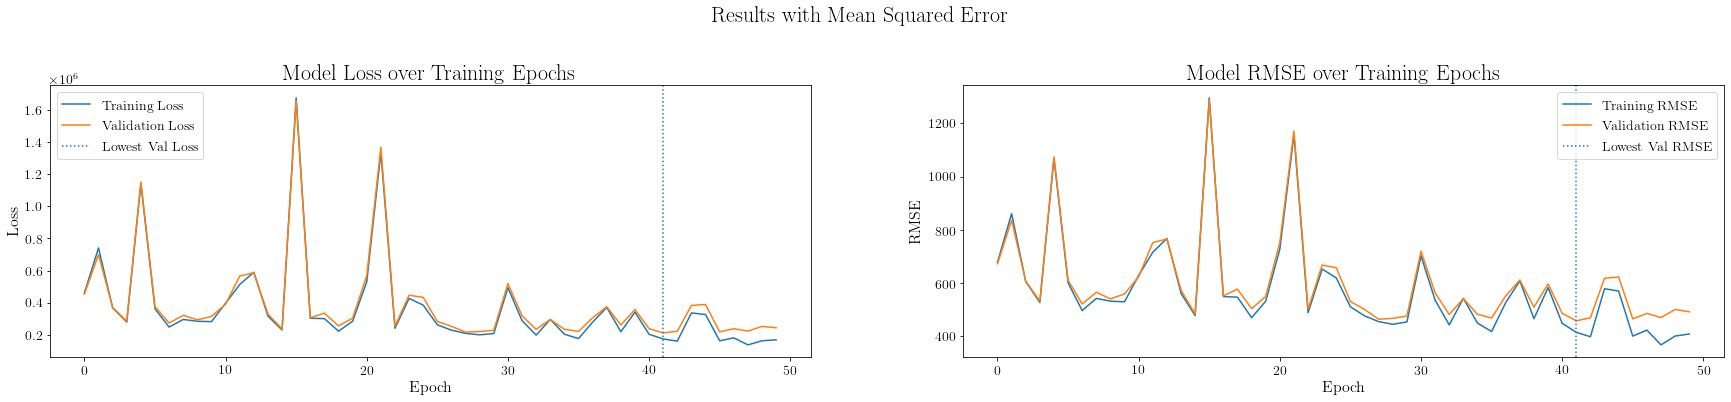

Lowest Validation Loss: 209770.9375 - Epoch: 41
Lowest RMSE: 458.0076 - Epoch 41


In [ ]:
small_fonts()
plot_results_reg(model_mse_result, "Results with Mean Squared Error")

In [ ]:
train_dataset_model.flip = False
model_mse_result_tr = test_regression(model_mse, train_dataset_model, train_dataset_model.n_images, device)

Actual Total Population for Test Set Regions: 30889244
    Predicted Total Population for Test Set Regions: 31756232
          
MAE: 180.71
          
RMSE: 415.49
          
R^2: 0.9450
          
Explained Variance: 0.9452


In [ ]:
model_mse_results_tst = test_regression(model_mse, test_dataset, test_dataset.n_images, device)

Actual Total Population for Test Set Regions: 4113870
    Predicted Total Population for Test Set Regions: 4038114
          
MAE: 172.70
          
RMSE: 467.12
          
R^2: 0.8511
          
Explained Variance: 0.8512


## Mean Absolute Error

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_mae = Neural_Network(config='16', batch_norm=True, mode='reg')
model_mae = model_mae.float()
model_mae.to(device)

summary(model_mae, input_size=(7,50,33))

print("Model Loaded")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 33]           4,096
       BatchNorm2d-2           [-1, 64, 50, 33]             128
              ReLU-3           [-1, 64, 50, 33]               0
            Conv2d-4           [-1, 64, 50, 33]          36,928
       BatchNorm2d-5           [-1, 64, 50, 33]             128
              ReLU-6           [-1, 64, 50, 33]               0
         MaxPool2d-7           [-1, 64, 25, 16]               0
            Conv2d-8          [-1, 128, 25, 16]          73,856
       BatchNorm2d-9          [-1, 128, 25, 16]             256
             ReLU-10          [-1, 128, 25, 16]               0
           Conv2d-11          [-1, 128, 25, 16]         147,584
      BatchNorm2d-12          [-1, 128, 25, 16]             256
             ReLU-13          [-1, 128, 25, 16]               0
        MaxPool2d-14           [-1, 128

In [ ]:
model_mae_result = run_training(model_mae,
                              dataset=train_dataset_model,
                              t_loader=train_loader,
                              v_loader=val_loader,
                              criterion=torch.nn.L1Loss(),
                              max_epochs=50,
                              flip=True,
                              flip_prob=0.25,
                              initial_lr=0.001,
                              pbar=False,
                              checkpoint=False,
                              save_as="regmae",
                              weight_decay=1e-5)

Epoch: 1
Training -- Avg loss: 433.7667, RMSE: 1117.7346
Validation -- Avg loss: 436.5263, RMSE: 1094.1477
Epoch: 2
Training -- Avg loss: 263.1368, RMSE: 690.2010
Validation -- Avg loss: 262.4295, RMSE: 678.4270
Epoch: 3
Training -- Avg loss: 637.0150, RMSE: 1582.9107
Validation -- Avg loss: 655.1203, RMSE: 1601.6952
Epoch: 4
Training -- Avg loss: 246.0429, RMSE: 613.9241
Validation -- Avg loss: 250.3837, RMSE: 620.7419
Epoch: 5
Training -- Avg loss: 254.4750, RMSE: 623.8473
Validation -- Avg loss: 261.0128, RMSE: 633.3904
Epoch: 6
Training -- Avg loss: 214.3948, RMSE: 577.6913
Validation -- Avg loss: 217.2852, RMSE: 576.8613
Epoch: 7
Training -- Avg loss: 209.6095, RMSE: 572.7848
Validation -- Avg loss: 215.6848, RMSE: 568.6731
Epoch: 8
Training -- Avg loss: 332.5010, RMSE: 804.3149
Validation -- Avg loss: 343.2713, RMSE: 816.9614
Epoch: 9
Training -- Avg loss: 223.0968, RMSE: 691.1723
Validation -- Avg loss: 225.1556, RMSE: 668.7255
Epoch: 10
Training -- Avg loss: 210.8402, RMSE: 535

In [ ]:
parameters = torch.load('/content/drive/My Drive/Dissertation Files/Models/regmae_LowestLossEpoch48')
model_mae.load_state_dict(parameters['model'])

<All keys matched successfully>

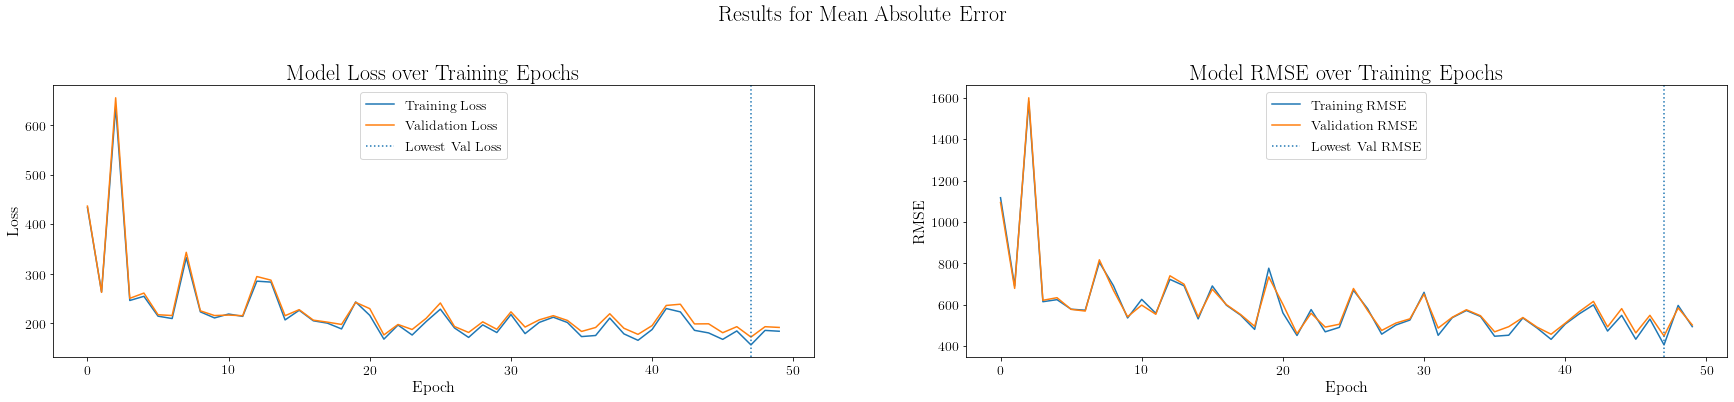

Lowest Validation Loss: 172.2426 - Epoch: 47
Lowest RMSE: 447.8381 - Epoch 47


In [ ]:
plot_results_reg(model_mae_result, "Results for Mean Absolute Error")

In [ ]:
train_dataset_model.flip = False
model_mae_result_tr = test_regression(model_mae, train_dataset_model, train_dataset_model.n_images, device)

Actual Total Population for Regions: 30889244
          
Predicted Total Population for Regions: 27261889
          
MAE: 185.33
          
RMSE: 494.84
          
R^2: 0.9220
          
Explained Variance: 0.9249


In [ ]:
model_mae_results_tst = test_regression(model_mae, test_dataset, test_dataset.n_images, device)

Actual Total Population for Regions: 4113870
          
Predicted Total Population for Regions: 4096561
          
MAE: 160.07
          
RMSE: 461.33
          
R^2: 0.8548
          
Explained Variance: 0.8548


## Smooth L1 Error

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_l1 = Neural_Network(config='16', batch_norm=True, mode='reg')
model_l1 = model_l1.float()
model_l1.to(device)

print("Model Loaded")

Model Loaded


In [ ]:
model_l1_result = run_training(model_l1,
                              dataset=train_dataset_model,
                              t_loader=train_loader,
                              v_loader=val_loader,
                              criterion=torch.nn.SmoothL1Loss(),
                              max_epochs=50,
                              flip=True,
                              flip_prob=0.25,
                              initial_lr=0.0001,
                              pbar=False,
                              checkpoint=False,
                              save_as="regl1",
                              weight_decay=1e-5)

Epoch: 1
Training -- Avg loss: 322.2495, RMSE: 738.3259
Validation -- Avg loss: 317.9557, RMSE: 731.5374
Epoch: 2
Training -- Avg loss: 245.2090, RMSE: 605.9105
Validation -- Avg loss: 246.7716, RMSE: 620.4636
Epoch: 3
Training -- Avg loss: 221.6879, RMSE: 559.7459
Validation -- Avg loss: 218.5260, RMSE: 560.2419
Epoch: 4
Training -- Avg loss: 593.8359, RMSE: 1555.6866
Validation -- Avg loss: 599.9492, RMSE: 1554.4910
Epoch: 5
Training -- Avg loss: 209.9255, RMSE: 531.9754
Validation -- Avg loss: 210.5247, RMSE: 550.7013
Epoch: 6
Training -- Avg loss: 220.5667, RMSE: 551.7339
Validation -- Avg loss: 224.8708, RMSE: 573.2073
Epoch: 7
Training -- Avg loss: 197.1293, RMSE: 523.4533
Validation -- Avg loss: 201.6605, RMSE: 539.7201
Epoch: 8
Training -- Avg loss: 190.8973, RMSE: 501.8861
Validation -- Avg loss: 200.7646, RMSE: 517.5830
Epoch: 9
Training -- Avg loss: 191.8518, RMSE: 492.5527
Validation -- Avg loss: 195.9524, RMSE: 502.3262
Epoch: 10
Training -- Avg loss: 200.8018, RMSE: 524.4

In [ ]:
parameters = torch.load('/content/drive/My Drive/Dissertation Files/Models/regl1_LowestLossEpoch28')
model_l1.load_state_dict(parameters['model'])

<All keys matched successfully>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


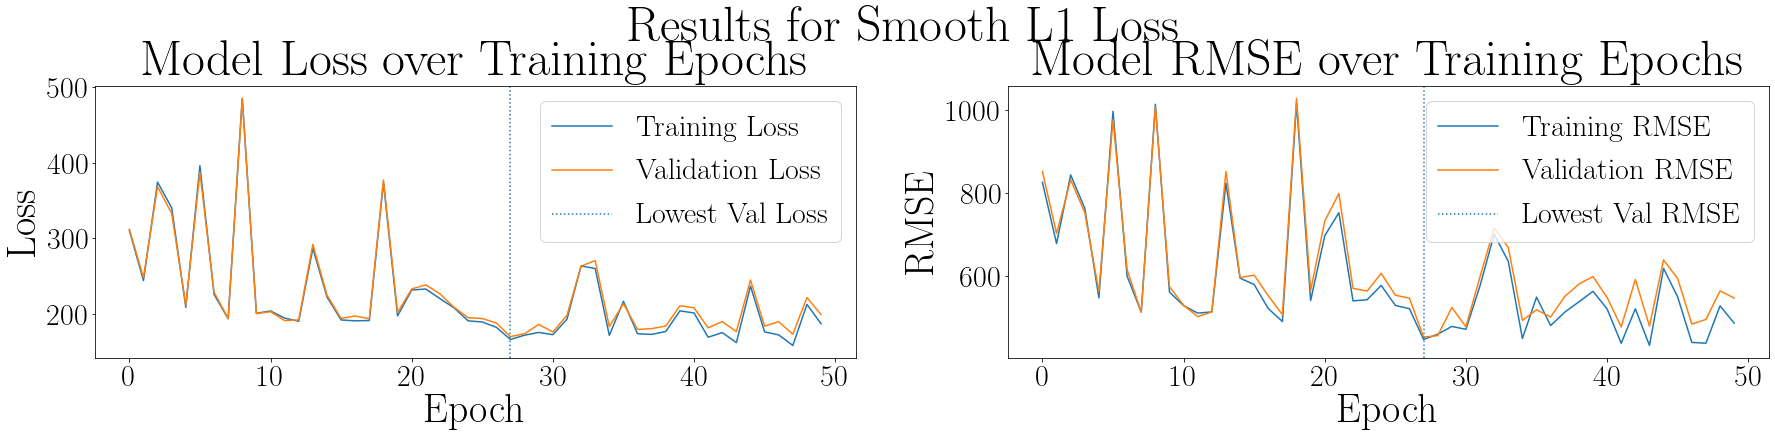

Lowest Validation Loss: 169.9553 - Epoch: 27
Lowest RMSE: 453.0502 - Epoch 27


In [ ]:
plot_results_reg(model_l1_result, "Results for Smooth L1 Loss")

In [ ]:
train_dataset_model.flip = False
model_l1_result_tr = test_regression(model_l1, train_dataset_model, train_dataset_model.n_images, device)

Actual Total Population for Test Set Regions: 30889244
    Predicted Total Population for Test Set Regions: 32446950
          
MAE: 187.46
          
RMSE: 488.61
          
R^2: 0.9240
          
Explained Variance: 0.9245


In [ ]:
model_l1_results_tst = test_regression(model_l1, test_dataset, test_dataset.n_images, device)

Actual Total Population for Test Set Regions: 4113870
    Predicted Total Population for Test Set Regions: 4387097
          
MAE: 153.88
          
RMSE: 428.86
          
R^2: 0.8745
          
Explained Variance: 0.8752
